In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from scipy.constants import c, pi
import scipy.special as sc

In [39]:
def a_plus(n, angle):
    N = np.round((pi + angle) / (2 * pi * n))
    return 2 * np.cos((2 * n * pi * N - angle) / 2) ** 2


def a_minus(n, angle):
    N = np.round((-pi + angle) / (2 * pi * n))
    return 2 * cos((2 * n * pi * N - angle) / 2) ** 2


def cot(x):
    return 1 / tan(x)


def F(x):
    
    if x < 0:
        return np.conj(F(-x))

    S, C = sc.fresnel(np.sqrt(2 / pi) * np.sqrt(x))
    res = (
        2j
        * sqrt(x)
        * exp(1j * x)
        * (
            (1 / 2 + 1j / 2)
            * sqrt(pi / 2)
            * ((-1 + 1j) * x * C + (1 + 1j) * sqrt(x**2) * S - 1j * x)
        )
        / x
    )


    return res


def D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro):

    factor = -exp(-1j * pi / 4) / (2 * n * sqrt(2 * pi * k) * sin(beta_0))

    D1 = (
        factor
        * cot((pi + (phi - phi_p)) / (2 * n))
        * F(k * Li * a_plus(n, phi - phi_p))
    )
    D2 = (
        factor
        * cot((pi - (phi - phi_p)) / (2 * n))
        * F(k * Li * a_minus(n, phi - phi_p))
    )
    D3 = (
        factor
        * cot((pi + (phi + phi_p)) / (2 * n))
        * F(k * Lrn * a_plus(n, phi + phi_p))
    )
    D4 = (
        factor
        * cot((pi - (phi + phi_p)) / (2 * n))
        * F(k * Lro * a_minus(n, phi + phi_p))
    )

    return D1 + D2 - D3 - D4, D1 + D2 + D3 + D4


def length(vec):
    return np.linalg.norm(vec)


def unit(vec):
    return vec / length(vec)


def Et(x, f=2.45e9):

    O = array([-2, 0, 0], dtype=float)  # TX point
    Q = array([0, 0, 1], dtype=float)  # Where diffraction occurs
    P = array([x, 0, 0], dtype=float)  # RX point

    polar = array([0, 0, 1], dtype=float)

    l = c / f
    k = 2 * pi / l

    n = 2  # because alpha = 0
    beta_0 = pi / 2

    e = array([0, 1, 0], dtype=float)  # Edge direction
    n0 = array([-1, 0, 0], dtype=float)  # Normal direction

    s_dir = unit(P - Q)
    s = length(P - Q)
    s_p_dir = unit(Q - O)
    a = length(Q - O)

    phi_p_dir = unit(-cross(e, s_p_dir))
    beta_0_p_dir = unit(-cross(phi_p_dir, s_p_dir))

    phi_dir = unit(cross(e, s_dir))
    beta_0_dir = unit(cross(phi_dir, s_dir))

    s_t_dir = unit(s_dir - dot(s_dir, e) * e)
    s_t_p_dir = unit(s_p_dir - dot(s_p_dir, e) * e)
    
    t = cross(n0, e)

    phi_p = pi - (pi - arccos(dot(-s_t_p_dir, t))) * sign(dot(-s_t_p_dir, n0))
    phi = pi - (pi - arccos(dot(s_t_dir, t))) * sign(dot(s_t_dir, n0))

    E_at_D = polar * exp(-1j * k * a) / a

    # Diffraction
    Li = Lro = Lrn = s
    D_s, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)
    EdP = zeros(2, dtype=complex64)
    
    Ei = array([dot(E_at_D, beta_0_p_dir), dot(E_at_D, phi_p_dir)])
    
    D = array([[-D_s, 0],[0, -D_h]], dtype=complex64)

    rho = a
    factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)
    #factor = np.sqrt(1 / s) * np.exp(-1j * k * s)

    Ed = factor * (D @ Ei)

    return Ed[0] *dot(beta_0_dir, polar) + Ed[1] * dot(phi_dir, polar)

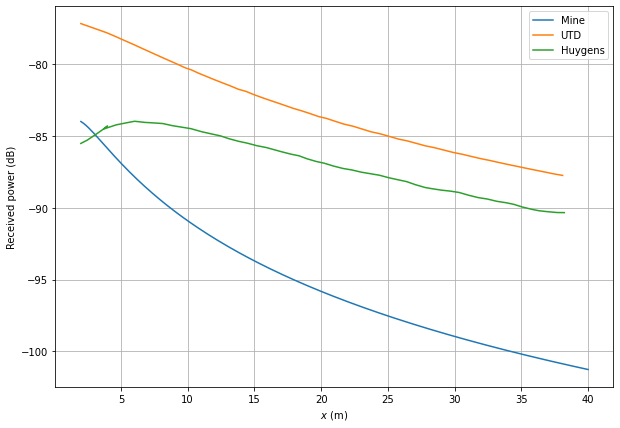

In [40]:
n = 200

x = np.linspace(2, 40, n)

plt.figure(figsize=(10, 7))

E = np.zeros(n, dtype=complex64)

for i in range(n):
    E[i] = Et(x[i])

P = 20 * np.log10(abs(E))
P = P - max(P)
P = P - 84
plt.plot(x, P, label="Mine")

d, UTD = np.loadtxt("/home/eertmans/Downloads/UTD.csv", delimiter=",").T
plt.plot(d, UTD, label="UTD")

d, H = np.loadtxt("/home/eertmans/Downloads/huygens.csv", delimiter=",").T
plt.plot(d, H, label="Huygens")
    
plt.xlabel(r"$x$ (m)")
plt.ylabel(r"Received power (dB)")
plt.legend()
plt.grid("on")